# 目的：チョコボールの商品別の重量比較
## アプローチ
- 正味重量をベイズ推定し、その傾向の違いを比較する

## モデル
- 重量分布は正規分布であると仮定する
- 事前分布は平均が仕様の正規分布とする（分散を大きくして一様分布みたいなものとする）

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as stats

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np

import pymc as pm

import ChocoUtils as cu

# データをロードする
- mysqlに貯めているデータをロード
- ヒストグラムを描画してみる

In [2]:
data = cu.get_data(db_file='../../data/choco-ball.db', filter_str="taste in (0, 13)")
#data = cu.get_data(db_file='../../data/choco-ball.db', filter_str="taste in (0, 1, 4, 7, 10, 11, 12)")
#data = cu.get_data(db_file='../../data/choco-ball.db', filter_str="taste in (0, 1, 10, 11, 12)")
#data = cu.get_data(db_file='../../data/choco-ball.db')
grp = data.groupby(['taste'])
grp.count()[['weight']]

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE taste in (0, 13);
Shape of MeasurementData(record_num, n_columns) : (360, 14)


,weight
taste,
0,351
13,9


# 基礎集計

## ヒストグラム

In [6]:
# 仕様の重量
spec = {0: 28.0, 1: 25.0, 4: 22.0, 7: 26.0, 10: 22.0, 11: 22.0, 12: 22.0, 13:28.0}
taste_name = {0: "peanut", 1: "strawberry", 4: "ama-zake",
              7: "pachi-pachi", 10: "pineapple", 11: "milk-caramel", 12: "choco-banana", 
              13:"white-peanut"}

/home/yoichi/.pyenv/versions/anaconda2-4.3.0/envs/choco3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


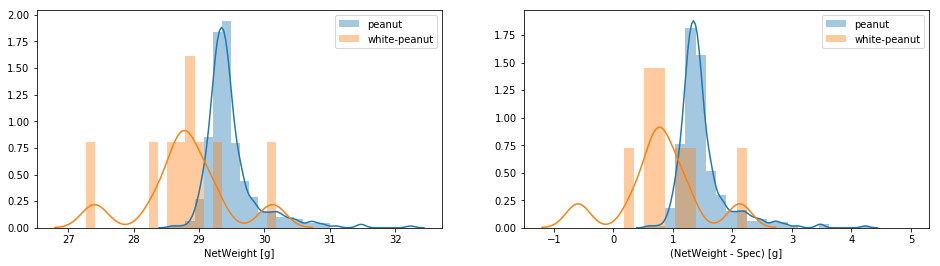

In [7]:
fig = plt.figure(figsize=(16, 4))
ax = fig.subplots(1, 2)

bins_m = np.linspace(0, 5.0, 30)
bins_p = np.linspace(27, 31, 30)
for key, value in grp:
    sns.distplot(value["net_weight"], bins=bins_p, hist=True, label=taste_name[key], ax=ax[0])
    sns.distplot((value["net_weight"] - spec[key]), bins=bins_m, hist=True, label=taste_name[key], ax=ax[1])
ax[0].set_xlabel("NetWeight [g]")
ax[1].set_xlabel("(NetWeight - Spec) [g]")
ax[0].legend()
ax[1].legend()
fig.savefig("weight_histogram.png")

日付で傾向を分ける

In [5]:
data_o = data.query('best_before < "2019-08-01"')
data_n = data.query('best_before >= "2019-08-01"')
print(data_o.groupby(['taste']).count()['weight'])
print(data_n.groupby(['taste']).count()['weight'])

taste
0    336
Name: weight, dtype: int64
taste
0     13
13     9
Name: weight, dtype: int64


/home/yoichi/.pyenv/versions/anaconda2-4.3.0/envs/choco3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


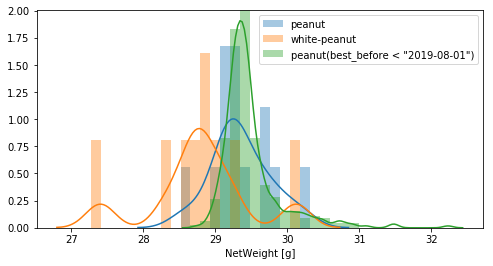

In [12]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

bins_p = np.linspace(27, 31, 30)
grp_n = data_n.groupby(['taste'])
grp_o = data_o.groupby(['taste'])
for key, value in grp_n:
    sns.distplot(value["net_weight"], bins=bins_p, hist=True, label=taste_name[key], ax=ax)
for key, value in grp_o:
    sns.distplot(value["net_weight"], bins=bins_p, hist=True, label='{}(best_before < "2019-08-01")'.format(taste_name[key]), ax=ax)
ax.set_xlabel("NetWeight [g]")
ax.legend()
fig.savefig("weight_histogram.png")

# 正規分布のパラメータを予測

## MCMCによるベイズ推定
### モデルの設定

In [ ]:
def getEstimatedWeightDist(values, spec, n_sample=15000, n_burn=5000):
    # 精度$\tau$(分散の逆数)
    tau = 1.0 / pm.Uniform("std", 0, 100)**2
    # 分布の中心
    ## 事前分布の中心として製品仕様を、tauを0.01(分散=100)
    center = pm.Normal("center", spec, 0.01)
    # 観測とモデルを結びつける
    observations = pm.Normal("obs", center, tau, value=values, observed=True)
    # Modelオブジェクト生成
    model = pm.Model([tau, center])
    
    # MCMC
    mcmc = pm.MCMC(model)
    mcmc.sample(n_sample, n_burn)
    
    return mcmc.trace("center")[:], mcmc.trace("std")[:]

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.subplots(1, 2)

bins = np.linspace(0, 3.0, 100)
bins_p = np.linspace(22.0, 30.0, 100)
result_dict = dict()
for key, value in grp:
    e_center, e_std = getEstimatedWeightDist(values=value['net_weight'].values, spec=spec[key])
    sns.distplot(e_center, bins=bins_p, label=taste_name[key], ax=ax[0])
    sns.distplot((e_center-spec[key]), bins=bins, label=taste_name[key], ax=ax[1])
    result_dict[key] = e_center
ax[0].set_title('estimated weight dist.')
ax[1].set_title('estimated weight dist. (spec=0)')
ax[0].set_xlabel("NetWeight [g]")
ax[1].set_xlabel("(NetWeight - Spec) [g]")
ax[0].legend()
ax[1].legend()
fig.savefig("weight_estimate_bayes.png")

In [ ]:
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 1)

bins = np.linspace(0, 3.0, 100)
bins_p = np.linspace(22.0, 30.0, 100)
result_dict = dict()
for key, value in grp:
    e_center, e_std = getEstimatedWeightDist(values=value['net_weight'].values, spec=spec[key])
    sns.distplot((e_center-spec[key]), bins=bins, label=taste_name[key], ax=ax)
    result_dict[key] = e_center
ax.set_title('estimated weight dist. (spec=0)')
ax.set_xlabel("(NetWeight - Spec) [g]")
ax.legend()
fig.savefig("weight_estimate_bayes_d.png")

In [ ]:
for k, v in result_dict.items():
    e1 = v.mean()
    e2 = (v - spec[k]).mean()
    print('| {} | {} | {} |'.format(taste_name[k], e1, e2))

In [ ]:
for k, v in result_dict.items():
    e2 = (v - spec[k]).mean()
    l, u = np.percentile((v - spec[k]), (5, 95))
    print('| {} | {} | {} | {} |'.format(taste_name[k], l, e2, u))

In [ ]:
fig = plt.figure(figsize=(16, 4))
ax = fig.subplots(1, 2)

bins = np.linspace(0, 3.0, 100)
bins_p = np.linspace(22.0, 30.0, 100)
for key, value in grp:
    e_center, e_std = getEstimatedWeightDist(values=value['net_weight'].values, spec=spec[key])
    ax[0].hist(e_center, bins=bins_p, alpha=0.5, edgecolor="#000000", lw=1, label=taste_name[key])
    ax[1].hist((e_center-spec[key]), bins=bins, alpha=0.5, edgecolor="#000000", lw=1, label=taste_name[key])
ax[0].set_title('estimated weight dist.')
ax[1].set_title('estimated weight dist. (spec=0)')
ax[0].legend()
ax[1].legend()
